In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby
from gwBackground import *
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline

from constants import *
import equations
# import redshiftPrior

# Add module

sys.path.append('../../modules')
from compute_omega_mcmc import (sample_dict_compute_injected_omega, calculate_num_injections,
                                PowerLawRedshiftPrior, BrokenPowerLawRedshiftPrior,
                               calculate_omega_gridded)

In [243]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 100 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = 1# (1/365.25/24) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
fs = 2048 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

In [244]:
# Regimbau Method
# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
del priors['luminosity_distance']
del priors['chirp_mass']
priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0# bilby.core.prior.Uniform(minimum=0, maximum=1, name='chi_1')
priors['chi_2'] = 0# bilby.core.prior.Uniform(minimum=0, maximum=1, name='chi_2')
priors['redshift'] = BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
freqs_tc, omega_tc = calculate_omega_gridded(priors)

19:56 bilby INFO    : Using aligned spin prior
19:56 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [245]:
# 100 weeks
omegas_m1_original = []
for ii in range(1):
    freqs_d, omega_gw_d, injections = sample_dict_compute_injected_omega(priors, T_obs,
                                         sampling_frequency=2048,
                                         duration=2, approximant='IMRPhenomD')
    omegas_m1_original.append(omega_gw_d)

2023-11-03 19:57:57.613 | INFO     | compute_omega_mcmc:draw_injections:116 - We are averaging over 71725.44902921855 1 / yr waveforms for 1 years
19:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-11-03 19:57:59.716 | INFO     | compute_omega_mcmc:sample_dict_compute_injected_omega:151 - Compute the total injected Omega for 71543 injections
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71543/71543 [00:35<00:00, 1999.72it/s]


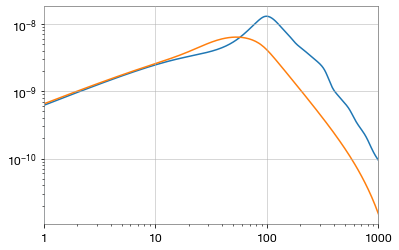

In [247]:
plt.loglog(freqs_d, 2 * np.array(omegas_m1_original).squeeze())
plt.loglog(freqs_tc, omega_tc * 1e9)
plt.xlim(1, 1000)
plt.show()

(0.0, 1.0)

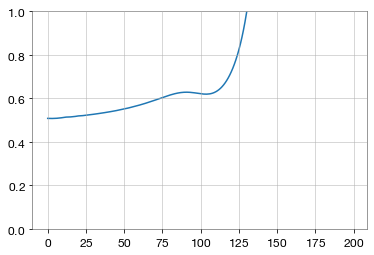

In [239]:
plt.plot(np.interp(freqs_tc, freqs_d,  np.array(omegas_m1_original).squeeze()) / (omega_tc * 1e9))
plt.ylim(0, 1)

# Compare dE/df methods

In [170]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=2,
    sampling_frequency=2048,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": "TaylorF2",
        "reference_frequency": 50,
        "minimum_frequency": 1
    }
)  # breaks down at M_tot * (1+z) ~ 1000, according to Xiao-Xiao and Haowen

# convert to seconds, set up frequency array for waveform
priors['mass_ratio'] = 1
freqs_psd = waveform_generator.frequency_array

19:00 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [182]:
print(test_injs)

{'mass_1': array([11.]), 'mass_ratio': array([1.]), 'chirp_mass': array([9.5760562]), 'luminosity_distance': array([1893.70380656]), 'dec': array([0.02572667]), 'ra': array([4.49167746]), 'theta_jn': array([0.]), 'psi': array([0.13830667]), 'phase': array([1.20613999]), 'chi_1': array([0.]), 'chi_2': array([0.]), 'redshift': array([2.]), 'geocent_time': array([0.1])}


19:13 bilby INFO    : Using aligned spin prior
19:13 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Projects/SURF2023/repositories/astrophysical_gwb/notebooks/sgwb_calculation/gwBackground.py:83: RuntimeWarning: divide by zero encountered in power
  dEdf_spectrum[inspiral] = np.power(freqs[inspiral],-1./3.)*np.power(1.+alpha.dot(vs[:,inspiral]),2.)
/Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/gwpy/plot/axes.py:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(self, **kw)


[0.00000000e+00 0.00000000e+00 1.35172221e+45 1.18083812e+45
 1.07286263e+45 9.95957440e+44 9.37231835e+44 8.90289877e+44
 8.51531634e+44 8.18747422e+44]
[           inf 2.00402175e+45 1.58616086e+45 1.38239572e+45
 1.25336249e+45 1.16127924e+45 1.09083700e+45 1.03443476e+45
 9.87791557e+44 9.48278110e+44]


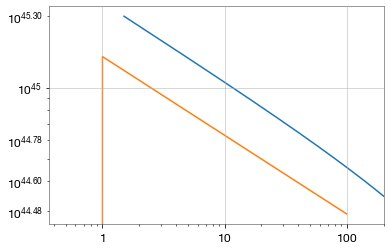

/var/folders/pw/q58shg_d4vz37qn56ds0zjm40000gn/T/ipykernel_5333/3176137203.py:51: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((direct_psd[shift_idxs:idx_max + shift_idxs] / waveform_psd[:idx_max])**-1)


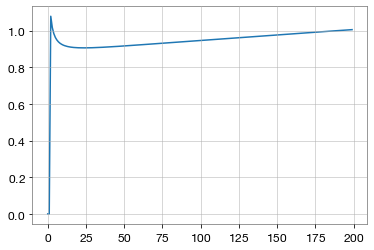

In [195]:
pc = 3e16 # meters

priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
m1 = 11
priors['mass_1'] = m1
priors['mass_ratio'] = 1
priors['chirp_mass'] = (m1 * m1)**(3/5) / (m1 + m1)**(1/5)
priors['theta_jn'] = 0
priors['chi_1'] = 0# bilby.core.prior.Uniform(minimum=0, maximum=1, name='chi_1')
priors['chi_2'] = 0# bilby.core.prior.Uniform(minimum=0, maximum=1, name='chi_2')
priors['redshift'] = 2
priors['geocent_time'] = 0.1

test_injs = priors.sample(1)




# luminosity_distance = equations.redshift_to_dl(test_injs['redshift'])
luminosity_distance = test_injs['luminosity_distance'] * pc * 1e6
polarizations = waveform_generator.frequency_domain_strain(test_injs)

m1 = test_injs['mass_1']
m2 = test_injs['mass_1'] * test_injs['mass_ratio']
Mtot = m1 + m2
eta = m1 * m2 / Mtot**2

waveform_psd =  (2 * np.pi**2 * c**3 / G / (4 * np.pi)) * (1 + test_injs['redshift'])**2 * luminosity_distance**2 * freqs_psd**2 * \
    np.abs(polarizations['plus']) ** 2 + np.abs(polarizations['cross']) ** 2

direct_psd = dEdf(Mtot[0], freqs_psd, eta=eta[0])

print(waveform_psd[:10])
print(direct_psd[:10])


Mc = np.power(eta,3./5.)*Mtot*Msun
amp = np.power(G*np.pi,2./3.)*np.power(Mc,5./3.)/3.

idx_max = np.argmin(np.abs(freqs_psd - 100))

df = freqs_psd[1] - freqs_psd[0]

shift_idxs = int(np.round((1 + test_injs['redshift']) * df))

plt.loglog(freqs_psd[:idx_max] * (1 + test_injs['redshift']), direct_psd[:idx_max])
plt.loglog(freqs_psd[:idx_max], waveform_psd[:idx_max])
plt.xlim(0, 200)
plt.show()

plt.plot((direct_psd[shift_idxs:idx_max + shift_idxs] / waveform_psd[:idx_max])**-1)
plt.show()